## Imports

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')


## Load data

In [2]:
# Data paths
labeled_data_path = '../data/data_labeled/'
unlabeled_data_path = '../data/data_unlabeled/'

# Image paths
img_test_unlabeled_path = '../data/data_labeled/Img_test/'
img_train_unlabeled_path = '../data/data_labeled/Img_train/'
X_img_path = '../data/data_unlabeled/Img/'

# Load csv's
X_test = pd.read_csv(labeled_data_path + 'X_test.csv')
X_train = pd.read_csv(labeled_data_path + 'X_train.csv')
y_test = pd.read_csv(labeled_data_path + 'y_test.csv', header=None)
y_train = pd.read_csv(labeled_data_path + 'y_train.csv', header=None)
X_unlabeled = pd.read_csv(unlabeled_data_path + 'X.csv')

X_test.head()

,age,blood pressure,calcium,cholesterol,hemoglobin,height,potassium,profession,sarsaparilla,smurfberry liquor,smurfin donuts,vitamin D,weight,img_filename
0,85,106.92,2.25,120.85,14.90,7.41,3.26,resource extraction,Low,High,Moderate,36.27,93.20,heart_0.png
1,130,94.73,2.61,121.74,16.88,7.53,4.74,manufacturing,Very high,Very high,Moderate,25.97,105.24,heart_6.png
2,180,110.31,2.47,75.35,15.52,8.02,4.29,manufacturing,High,Moderate,Very low,37.53,100.61,heart_7.png
3,78,95.46,2.28,125.30,11.68,7.75,4.17,services,Very low,Low,Moderate,28.19,103.94,heart_10.png
4,116,106.13,2.11,89.98,14.83,7.89,4.73,resource extraction,Low,Very high,Low,30.07,82.53,heart_11.png


## Preprocess data

In [3]:

#Save data before cleaning
X_train_clean = X_train.copy()
X_test_clean = X_test.copy()

X_train = X_train.drop(columns=['img_filename'])
X_test = X_test.drop(columns=['img_filename'])

X_train = pd.get_dummies(X_train, columns=['profession'])
X_test = pd.get_dummies(X_test, columns=['profession'])

# Ordinal encoding of consumption features
consumption_map = {
    'Very low': 1,
    'Low': 2,
    'Moderate': 3,
    'High': 4,
    'Very high': 5
}

for col in ['sarsaparilla', 'smurfberry liquor', 'smurfin donuts']:
    X_train[col] = X_train[col].map(consumption_map)
    X_test[col] = X_test[col].map(consumption_map)

# Split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print("Train subset:", X_train.shape)
print("Validation set:", X_val.shape)

# Standardize numerical features
numerical_features = [
    'age', 'blood pressure', 'calcium', 'cholesterol',
    'hemoglobin', 'height', 'potassium',
    'vitamin D', 'weight'
]

scX = StandardScaler()
X_train[numerical_features] = scX.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scX.transform(X_test[numerical_features])

X_test.head()


Train subset: (800, 18)
Validation set: (200, 18)


,age,blood pressure,calcium,cholesterol,hemoglobin,height,potassium,sarsaparilla,smurfberry liquor,smurfin donuts,vitamin D,weight,profession_administration and governance,profession_craftsmanship,profession_food production,profession_manufacturing,profession_resource extraction,profession_services
0,-1.088731,-0.153842,-0.965800,0.382095,0.328558,-0.463442,-2.107149,2,4,3,1.202304,-0.726562,False,False,False,False,True,False
1,0.404898,-1.246817,0.777981,0.422910,1.290066,-0.161914,0.864484,5,5,3,-0.849324,-0.021621,False,False,False,True,False,False
2,2.064486,0.150110,0.099844,-1.704512,0.629636,1.069325,-0.039053,4,3,1,1.453280,-0.292707,False,False,False,True,False,False
3,-1.321073,-1.181364,-0.820485,0.586170,-1.235107,0.390887,-0.279996,1,2,3,-0.407129,-0.097736,False,False,False,False,False,True
4,-0.059787,-0.224675,-1.643937,-1.033588,0.294565,0.742670,0.844406,2,5,2,-0.032657,-1.351289,False,False,False,False,True,False


## Feature selection

In [4]:

def evaluate_feature_selection_linear_regression(X_train, X_test, y_train, y_test, model, selected_features):
    """
    Entraîne et évalue un modèle de régression linéaire avec les variables sélectionnées.
    Affiche les variables retenues, le RMSE et le R² sur le jeu de test.
    """

    # Entraînement du modèle
    model.fit(X_train[selected_features], y_train.values.ravel())

    # Prédictions sur le test set
    y_pred = model.predict(X_test[selected_features])

    # Évaluation
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Affichage des résultats
    print("Selected features:")
    for feature in selected_features:
        print(f"- {feature}")
    print("----------------------------------")
    print(f"RMSE : {rmse:.3f}")
    print(f"R² :   {r2:.3f}") 

### Filter

##### Mutual information

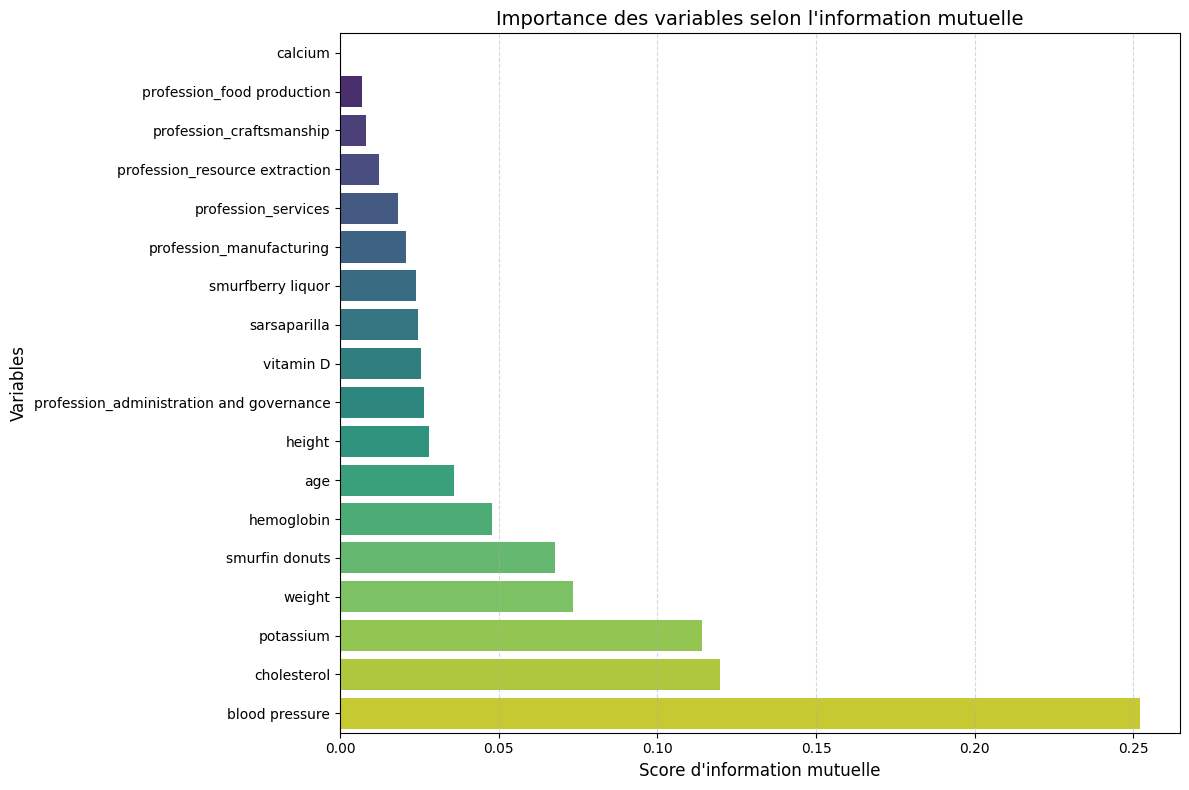

In [5]:
mi_scores = mutual_info_regression(X_train, y_train.values.ravel())
mi_series = pd.Series(mi_scores, index=X_train.columns).sort_values(ascending=True)


# Visualisation améliorée
plt.figure(figsize=(12, 8))
sns.barplot(x=mi_series.values, y=mi_series.index, palette="viridis")
plt.title("Importance des variables selon l'information mutuelle", fontsize=14)
plt.xlabel("Score d'information mutuelle", fontsize=12)
plt.ylabel("Variables", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [6]:
def find_best_top_k(mi_series, X_train, X_test, y_train, y_test, k_min=2, k_max=20):
    best_rmse = float('inf')
    best_k = None
    best_features = None
    best_r2 = None

    for k in range(k_min, k_max + 1):
        selected_features = mi_series.sort_values(ascending=False).head(k).index.tolist()
        model = LinearRegression()
        model.fit(X_train[selected_features], y_train.values.ravel())
        y_pred = model.predict(X_test[selected_features])
        rmse = root_mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        if rmse < best_rmse:
            best_rmse = rmse
            best_k = k
            best_features = selected_features
            best_r2 = r2

    print("best top k found :", best_k)
    print(f"RMSE : {best_rmse:.4f}")
    print(f"R²   : {best_r2:.4f}")
    print("\nSelected features :")
    for feat in best_features:
        print(f"- {feat}")

find_best_top_k(mi_series, X_train, X_test, y_train, y_test)

best top k found : 8
RMSE : 0.0556
R²   : 0.5407

Selected features :
- blood pressure
- cholesterol
- potassium
- weight
- smurfin donuts
- hemoglobin
- age
- height


##### Corelation filter

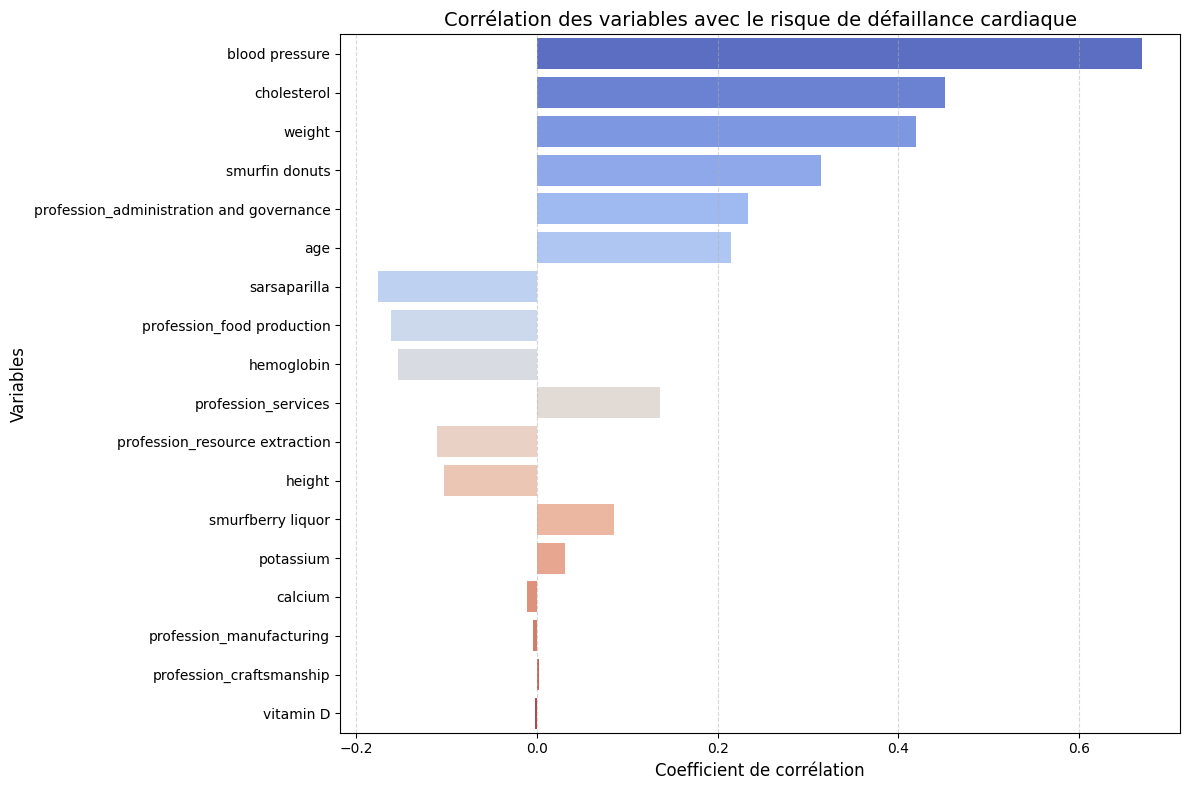

In [7]:
# Corrélation entre chaque variable et la cible
correlations = pd.Series([
    np.corrcoef(X_train[col], y_train.values.ravel())[0, 1]
    for col in X_train.columns
], index=X_train.columns)

# Tri des corrélations absolues
correlations_sorted = correlations.sort_values(key=lambda x: x.abs(), ascending=False)

# Visualisation
plt.figure(figsize=(12, 8))
sns.barplot(x=correlations_sorted.values, y=correlations_sorted.index, palette="coolwarm")
plt.title("Corrélation des variables avec le risque de défaillance cardiaque", fontsize=14)
plt.xlabel("Coefficient de corrélation", fontsize=12)
plt.ylabel("Variables", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [8]:
def find_best_corr_threshold(X_train, X_test, y_train, y_test, thresholds=np.arange(0.01, 0.31, 0.01)):
    best_rmse = float('inf')
    best_threshold = None
    best_features = None
    best_r2 = None

    # Corrélation entre chaque variable et la cible
    correlations = pd.Series([
        np.corrcoef(X_train[col], y_train.values.ravel())[0, 1]
        for col in X_train.columns
    ], index=X_train.columns)

    for threshold in thresholds:
        selected_features = correlations[correlations.abs() > threshold].index.tolist()

        if len(selected_features) == 0:
            continue  # ignorer les seuils trop élevés

        model = LinearRegression()
        model.fit(X_train[selected_features], y_train.values.ravel())
        y_pred = model.predict(X_test[selected_features])
        rmse = root_mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        if rmse < best_rmse:
            best_rmse = rmse
            best_threshold = threshold
            best_features = selected_features
            best_r2 = r2

    print("Best threshold found:", best_threshold)
    print(f"RMSE : {best_rmse:.4f}")
    print(f"R²   : {best_r2:.4f}")
    print("\nSelected features:")
    for feat in best_features:
        print(f"- {feat}")

find_best_corr_threshold(X_train, X_test, y_train, y_test)

Best threshold found: 0.02
RMSE : 0.0558
R²   : 0.5377

Selected features:
- age
- blood pressure
- cholesterol
- hemoglobin
- height
- potassium
- sarsaparilla
- smurfberry liquor
- smurfin donuts
- weight
- profession_administration and governance
- profession_food production
- profession_resource extraction
- profession_services


##### Maximum relevance and minimum redundancy

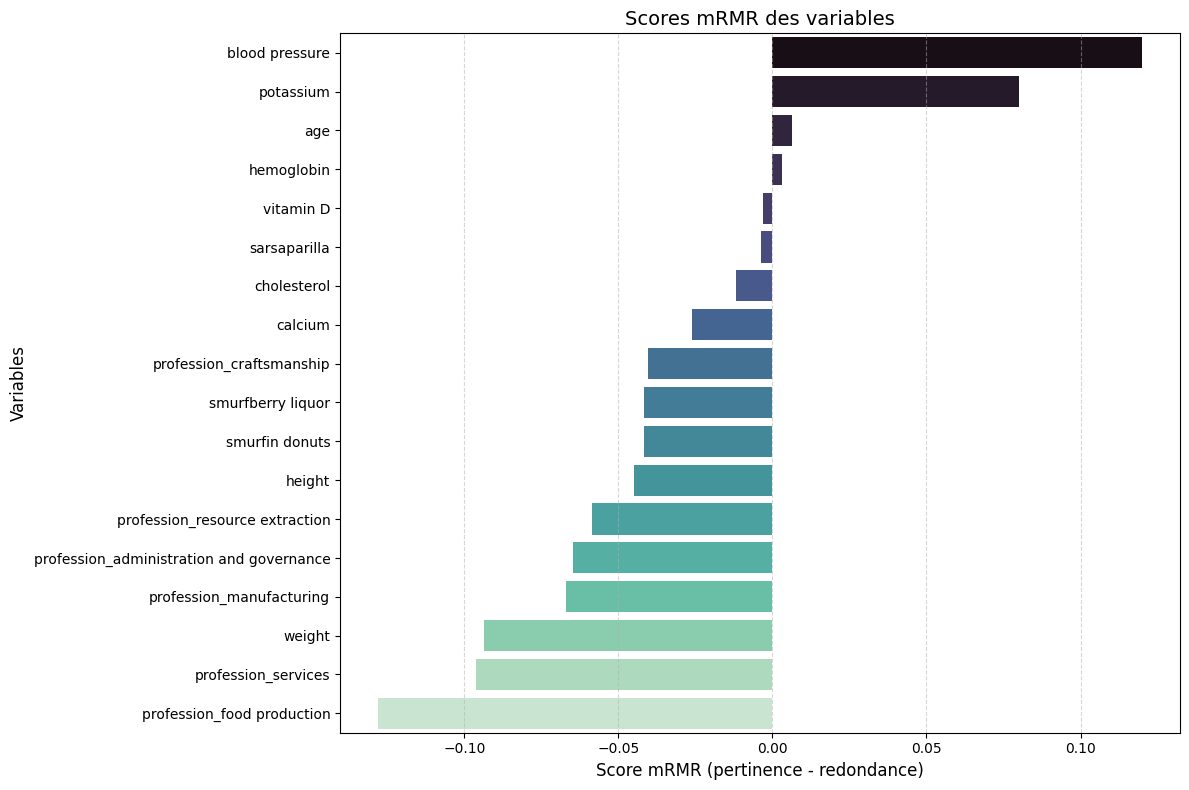

In [9]:

def compute_mrmr_scores(X, y):
    relevance = pd.Series(mutual_info_regression(X, y.values.ravel(), random_state=42), index=X.columns)
    redundancy = X.corr().abs()

    scores = {}
    for feature in X.columns:
        rel = relevance[feature]
        red = redundancy[feature].drop(feature).mean()  # moyenne des corrélations avec les autres
        scores[feature] = rel - red  # mRMR = pertinence - redondance

    return pd.Series(scores).sort_values(ascending=False)


mrmr_scores = compute_mrmr_scores(X_train, y_train)

plt.figure(figsize=(12, 8))
sns.barplot(x=mrmr_scores.values, y=mrmr_scores.index, palette="mako")
plt.title("Scores mRMR des variables", fontsize=14)
plt.xlabel("Score mRMR (pertinence - redondance)", fontsize=12)
plt.ylabel("Variables", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



In [10]:
def find_best_mrmr_top_k(mrmr_series, X_train, X_test, y_train, y_test, k_min=2, k_max=20):
    best_rmse = float('inf')
    best_k = None
    best_features = None
    best_r2 = None

    for k in range(k_min, k_max + 1):
        selected_features = mrmr_series.head(k).index.tolist()
        model = LinearRegression()
        model.fit(X_train[selected_features], y_train.values.ravel())
        y_pred = model.predict(X_test[selected_features])
        rmse = root_mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        if rmse < best_rmse:
            best_rmse = rmse
            best_k = k
            best_features = selected_features
            best_r2 = r2

    print("\nBest top_k mRMR :", best_k)
    print(f"RMSE : {best_rmse:.4f}")
    print(f"R²   : {best_r2:.4f}")
    print("\nSelected features :")
    for feat in best_features:
        print(f"- {feat}")

find_best_mrmr_top_k(mrmr_scores, X_train, X_test, y_train, y_test)



Best top_k mRMR : 17
RMSE : 0.0558
R²   : 0.5389

Selected features :
- blood pressure
- potassium
- age
- hemoglobin
- vitamin D
- sarsaparilla
- cholesterol
- calcium
- profession_craftsmanship
- smurfberry liquor
- smurfin donuts
- height
- profession_resource extraction
- profession_administration and governance
- profession_manufacturing
- weight
- profession_services


### Wapers

##### Forward search

##### Backward search

### Embedded methods